# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing important libarary
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm

from progiter import ProgIter
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import random

In [3]:
con = sqlite3.connect("database.sqlite")

In [4]:
amzn = pd.read_sql_query('''SELECT * 
                            FROM Reviews 
                            WHERE Score != 3 
                            ORDER BY Time ''', con)

In [5]:
def partition(score):
    if score < 3:
        return 0
    else : 
        return 1
amzn_score = amzn["Score"] 
filter_amzn = amzn_score.map(partition)
amzn['Score'] = filter_amzn

In [6]:
#Deduplication of entries
final= amzn.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
del amzn

In [8]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [9]:
final = final.iloc[0:100000]

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100000/100000 [03:12<00:00, 520.14it/s]


In [13]:
'''len_of_review = []
for i in range(0, len(preprocessed_reviews)):
    len_of_review.append(len(preprocessed_reviews[i]))
'''

'len_of_review = []\nfor i in range(0, len(preprocessed_reviews)):\n    len_of_review.append(len(preprocessed_reviews[i]))\n'

In [14]:
'''
xtr_len_rvw = np.asarray((len_of_review[slice(0,40000)])).reshape(-1,1)
xcv_len_rvw = np.asarray((len_of_review[slice(40000,47000)])).reshape(-1,1)
xts_len_rvw = np.asarray((len_of_review[slice(47000,54000)])).reshape(-1,1)
'''

'\nxtr_len_rvw = np.asarray((len_of_review[slice(0,40000)])).reshape(-1,1)\nxcv_len_rvw = np.asarray((len_of_review[slice(40000,47000)])).reshape(-1,1)\nxts_len_rvw = np.asarray((len_of_review[slice(47000,54000)])).reshape(-1,1)\n'

In [15]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,70000)]
x_cv = preprocessed_reviews[slice(70000, 85000)]
x_test = preprocessed_reviews[slice(85000, 100000)]
y_train = final.iloc[:70000, 6]
y_cv = final.iloc[70000:85000, 6]
y_test = final.iloc[85000:100000, 6]



## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [16]:
# Please write all the code with proper documentation

In [17]:
# Please write all the code with proper documentation
#defining function for Bag of words
def bow(para, bow_x_cv, bow_x_test):  
    bow_vect = CountVectorizer() #in scikit-learn
    bow_x_train = bow_vect.fit_transform(para)
    bow_x_cv = bow_vect.transform(x_cv)
    bow_x_test = bow_vect.transform(x_test)
    return bow_x_train, bow_x_cv, bow_x_test , bow_vect


In [18]:
bow_x_train, bow_x_cv, bow_x_test , bow_vect = bow(x_train, x_cv, x_test)

In [19]:
bow_x_train

<70000x49452 sparse matrix of type '<class 'numpy.int64'>'
	with 2190336 stored elements in Compressed Sparse Row format>

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

stdize = StandardScaler(with_mean=False)
bow_x_train = stdize.fit_transform(bow_x_train)
bow_x_cv = stdize.transform(bow_x_cv)
bow_x_test = stdize.transform(bow_x_test)

In [21]:
bow_x_train

<70000x49452 sparse matrix of type '<class 'numpy.float64'>'
	with 2190336 stored elements in Compressed Sparse Row format>

In [22]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    bow_clf = LogisticRegression(penalty='l1', C = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, y_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|████████████████████████████████████████| 8/8 [3:04:31<00:00, 2886.25s/it]


In [23]:
bowl1_optimal_c = c[(auc_cv.index(max(auc_cv)))]

In [24]:
#Taking log of alpha value to print easely on graph with correcsponding auc
log_c = []
for i in c:
    log_c.append(math.log10(i))
log_c    

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

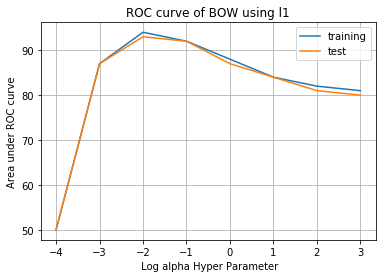

In [25]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW using l1")
plt.grid()
plt.show()

In [26]:
bow_clf = LogisticRegression(penalty= 'l1',C = bowl1_optimal_c)
bow_clfl1 = bow_clf
bow_clf.fit(bow_x_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

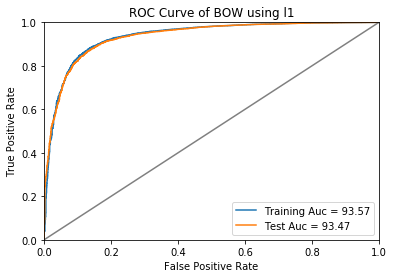

In [27]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
bowl1_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
bowl1_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW using l1")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [28]:
y_pred_test = bow_clf.predict(bow_x_test)

In [29]:
y_pred_cv = bow_clf.predict(bow_x_cv)

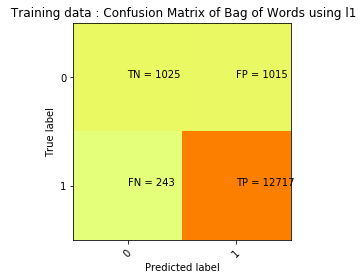

In [30]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of Bag of Words using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

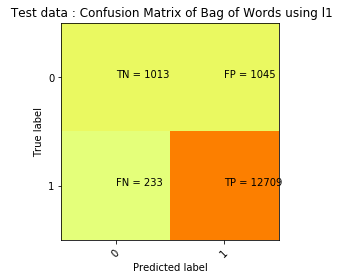

In [31]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Bag of Words using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [32]:
# Please write all the code with proper documentation

In [33]:
#Saving all weight corresponding to fearure or word into an array
bow_wgt_vec = bow_clf.coef_
type(bow_wgt_vec)

numpy.ndarray

In [34]:
sparse_wgt = []
not_sparse_wgt = []
k = 0
for w in bow_wgt_vec: 
    for w in tqdm(w):     
        if 0 == w :
            sparse_wgt.append(bow_vect.get_feature_names()[k])
            k = k+1
        else :
            not_sparse_wgt.append(bow_vect.get_feature_names()[k])
            k = k+1

100%|██████████████████████████████████| 49452/49452 [2:35:52<00:00,  5.54it/s]


In [35]:
len(sparse_wgt)+len(not_sparse_wgt)

49452

In [36]:
# printing total of number of sparse weight while using l1 regularization
print("Total number of sparse weight : ", len(sparse_wgt))
print("Total number of non sparse weight : ", len(not_sparse_wgt))

Total number of sparse weight :  45398
Total number of non sparse weight :  4054


In [37]:
# There are 6581 sparse weight, printing all is not good choice. so we going 
# to print only 50 words
print("50 words which have sparse or 0 weight :\n", sparse_wgt[0:50])


50 words which have sparse or 0 weight :
 ['aa', 'aaa', 'aaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaah', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aaahs', 'aachen', 'aad', 'aadp', 'aafco', 'aahhed', 'aahing', 'aand', 'aash', 'ab', 'aback', 'abandoned', 'abaolutely', 'abattoir', 'abba', 'abbey', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abcs', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abeneficial', 'aberdeen', 'abernook', 'aberration', 'abhor', 'abhorrent', 'abi', 'abid', 'abide', 'abigirl', 'abilities', 'ability', 'abit']


In [38]:
# There are 1780  non sparse weight, printing all is not good choice. so we going 
# to print only 50 words
print("50 words which have non sparse or not 0 weight : \n", not_sparse_wgt[0:50])


50 words which have non sparse or not 0 weight : 
 ['aaaaa', 'aagh', 'aardvark', 'abandon', 'abandoning', 'ablaze', 'able', 'abortions', 'absurd', 'abysmal', 'acai', 'acceleradetests', 'accepeted', 'acclimating', 'accordng', 'accpetable', 'accuracy', 'accurate', 'accused', 'achiote', 'acidification', 'acidity', 'acknowledgement', 'acquired', 'across', 'activated', 'activations', 'adavance', 'add', 'addage', 'addams', 'addicitve', 'addicted', 'addicting', 'addiction', 'addictive', 'addressed', 'adds', 'ade', 'adhesive', 'admit', 'adopted', 'adored', 'adovada', 'adress', 'adrift', 'ads', 'adulterated', 'adulturated', 'advantix']


In [39]:
del sparse_wgt
del not_sparse_wgt

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [40]:
# Please write all the code with proper documentation

In [41]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    bow_clf = LogisticRegression(penalty='l2', C = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, y_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|████████████████████████████████████████████| 8/8 [05:36<00:00, 54.81s/it]


In [42]:
bowl2_optimal_c = c[(auc_cv.index(max(auc_cv)))]

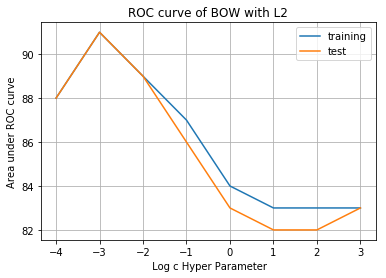

In [43]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log c Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of BOW with L2")
plt.grid()
plt.show()

In [44]:
bow_clf = LogisticRegression(penalty= 'l2',C = bowl2_optimal_c)
bow_clfl2 = bow_clf
bow_clf.fit(bow_x_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

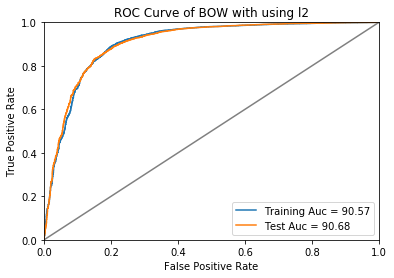

In [45]:
#auc curve of optimal k on validation and test data
y_predk_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
bowl2_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = bow_clf.predict_proba(bow_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
bowl2_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of BOW with using l2")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [46]:
y_pred_test = bow_clf.predict(bow_x_test)

In [47]:
y_pred_cv = bow_clf.predict(bow_x_cv)

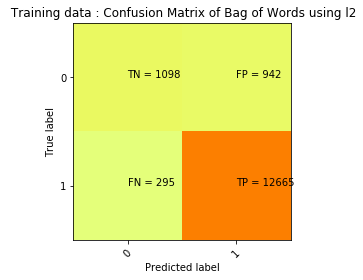

In [48]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of Bag of Words using l2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

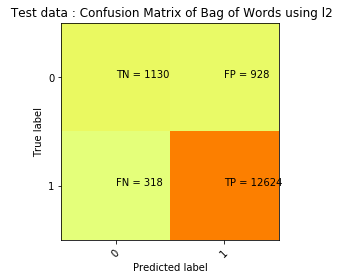

In [49]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Bag of Words using l2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [50]:
# Please write all the code with proper documentation

In [51]:
bow_x_train.data = bow_x_train.data.astype(float)
bow_x_cv.data = bow_x_cv.data.astype(float)
bow_x_test.data = bow_x_test.data.astype(float)

In [52]:
bow_x_train.data += 0.00004
bow_x_cv.data += 0.00004
bow_x_test.data += 0.00004

In [53]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    bow_clf = LogisticRegression(penalty='l2', C = i)
    # fitting the model on crossvalidation train
    bow_clf.fit(bow_x_train, y_train)
    
    y_pred_proba = bow_clf.predict_proba(bow_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = bow_clf.predict_proba(bow_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

100%|████████████████████████████████████████████| 8/8 [05:57<00:00, 59.86s/it]


In [54]:
bowptl2_optimal_c = c[(auc_cv.index(max(auc_cv)))]

In [55]:
bow_clf = LogisticRegression(penalty= 'l2',C = bowptl2_optimal_c)
bow_clf.fit(bow_x_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
wgt = bow_clfl2.coef_ 
wgt_dash = bow_clf.coef_

In [57]:
wgt = wgt + 0.000001
wgt_dash = wgt_dash + 0.000001

In [58]:
delta = []
for i in range(len(wgt[0])):
    delta.append(((wgt[0][i] - wgt_dash[0][i]) * 100 ) / wgt[0][i] )
        

In [59]:
sorted_delta = sorted(delta, reverse = True)

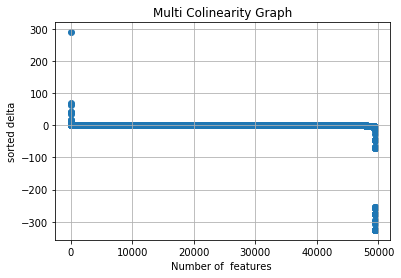

In [60]:
plt.scatter(range(0, len(wgt[0])), sorted_delta)
plt.xlabel("Number of  features ")
plt.ylabel("sorted delta")
plt.title("Multi Colinearity Graph")
plt.grid()
plt.show()

In [64]:
from tqdm import tqdm_notebook as tqdm
colinear_word = []
not_colinear_word  = []
thresold_delta = 0
for i in tqdm(range(len(delta))):
    if thresold_delta == delta[i]:
        not_colinear_word.append(bow_vect.get_feature_names()[i])
    else:
        colinear_word.append(bow_vect.get_feature_names()[i])

In [65]:
print("Total number of colinear words : ", len(colinear_word))
print("Total number of Not colinear words : ", len(not_colinear_word))

Total number of colinear words :  49452
Total number of Not colinear words :  0


In [66]:
#printing 50  colinear word 
print("50 colinear words :\n", (colinear_word[0:50]))

50 colinear words :
 ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaah', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aaahs', 'aachen', 'aad', 'aadp', 'aafco', 'aagh', 'aahhed', 'aahing', 'aand', 'aardvark', 'aash', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abaolutely', 'abattoir', 'abba', 'abbey', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abcs', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abeneficial', 'aberdeen', 'abernook', 'aberration', 'abhor', 'abhorrent', 'abi', 'abid']


In [67]:
#printing 50 not colinear word 
print("50 not colinear words :\n", (not_colinear_word[0:50]))

50 not colinear words :
 []


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [68]:
# Please write all the code with proper documentation

In [69]:
bow_features_prob = bow_clfl1.coef_

In [70]:
bow_pos_df = pd.DataFrame({'log prob': bow_features_prob[0],
                   'word': bow_vect.get_feature_names()[:]
                  })
bow_pos_largest_10= bow_pos_df.nlargest(10, 'log prob')

In [71]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class positive or 1 of BOW using L1")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_pos_largest_10["log prob"].values[i] ,\
               bow_pos_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class positive or 1 of BOW using L1
+-----------------+--------------------------+-----------+
| Top ten fetures | Features Log Probability |    Word   |
+-----------------+--------------------------+-----------+
|        1        |    0.6760073652707419    |   great   |
|        2        |   0.47302788397371226    |    best   |
|        3        |    0.432856555143237     | delicious |
|        4        |    0.3386292687003001    |  perfect  |
|        5        |    0.3362274625456101    |    good   |
|        6        |    0.2960099105467483    |    love   |
|        7        |    0.2951680756600804    |   loves   |
|        8        |   0.29187618819891703    | excellent |
|        9        |    0.284933567641483     | wonderful |
|        10       |   0.23326601890362525    |    nice   |
+-----------------+--------------------------+-----------+


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation

In [73]:
bow_neg_df = pd.DataFrame({'log prob': bow_features_prob[0],
                   'word': bow_vect.get_feature_names()[:]
                  })
bow_neg_largest_10= bow_neg_df.nsmallest(10, 'log prob')


In [74]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class negative or 0 of BOW using l1")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, bow_neg_largest_10["log prob"].values[i] , \
                    bow_neg_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class negative or 0 of BOW using l1
+-----------------+--------------------------+---------------+
| Top ten fetures | Features Log Probability |      Word     |
+-----------------+--------------------------+---------------+
|        1        |   -0.4792746430679479    |      not      |
|        2        |   -0.20521999814999095   |     worst     |
|        3        |   -0.20485059069053269   |  disappointed |
|        4        |   -0.16275897460448785   |    terrible   |
|        5        |    -0.15662999684728     |     awful     |
|        6        |   -0.1404328756706297    |     bland     |
|        7        |   -0.13674852787984992   | disappointing |
|        8        |   -0.1356643506921463    |     money     |
|        9        |   -0.13523151663298966   | unfortunately |
|        10       |   -0.13378959968353477   |    horrible   |
+-----------------+--------------------------+---------------+


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [75]:
# Please write all the code with proper documentation

In [76]:
def tfidf(preprocessed_reviews, x_cv, x_test):
    tf_idf_vect = TfidfVectorizer()
    tfidf_x_train = tf_idf_vect.fit_transform(preprocessed_reviews)
    tfidf_x_cv = tf_idf_vect.transform(x_cv)
    tfidf_x_test = tf_idf_vect.transform(x_test)
    return tfidf_x_train, tfidf_x_cv, tfidf_x_test, tf_idf_vect

In [77]:
tfidf_x_train, tfidf_x_cv, tfidf_x_test, tfidfl2_vect = tfidf(x_train, x_cv, x_test)

In [78]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

stdize = StandardScaler(with_mean=False)
tfidf_x_train = stdize.fit_transform(tfidf_x_train)
tfidf_x_cv = stdize.transform(tfidf_x_cv)
tfidf_x_test = stdize.transform(tfidf_x_test)

In [79]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l1', C = i)
    # fitting the model on crossvalidation train
    clf.fit(tfidf_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [80]:
tfidfl1_optimal_c = c[(auc_cv.index(max(auc_cv)))]

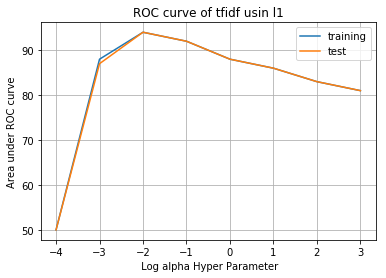

In [81]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf usin l1")
plt.grid()
plt.show()

In [82]:
clf = LogisticRegression(penalty= 'l1',C = tfidfl1_optimal_c)
clf.fit(tfidf_x_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

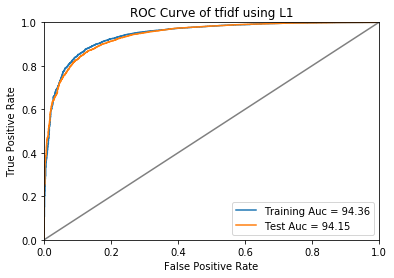

In [83]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidfl1_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidfl1_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf using L1")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [84]:
y_pred_test = clf.predict(tfidf_x_test)
y_pred_cv = clf.predict(tfidf_x_cv)

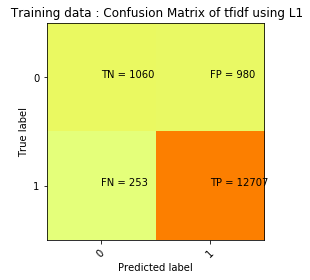

In [85]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of tfidf using L1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

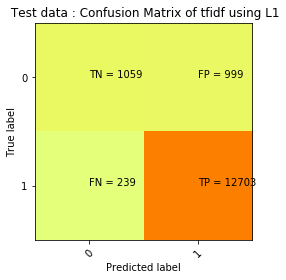

In [86]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of tfidf using L1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [87]:
# Please write all the code with proper documentation

In [88]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l2', C = i)
    # fitting the model on crossvalidation train
    clf.fit(tfidf_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(tfidf_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(tfidf_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [89]:
tfidfl2_optimal_c = c[(auc_cv.index(max(auc_cv)))]

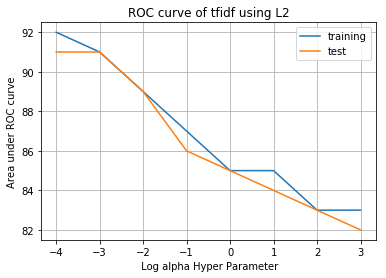

In [90]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf using L2")
plt.grid()
plt.show()

In [91]:
clf = LogisticRegression(penalty= 'l2',C = tfidfl2_optimal_c)
tfidfl2_clf = clf
clf.fit(tfidf_x_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

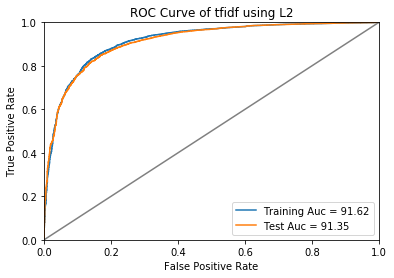

In [92]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidfl2_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(tfidf_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidfl2_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf using L2")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [93]:
y_pred_test = clf.predict(tfidf_x_test)
y_pred_cv = clf.predict(tfidf_x_cv)

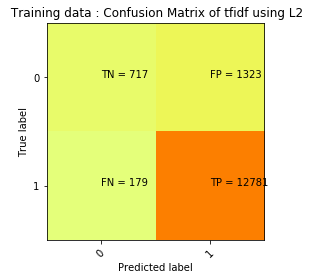

In [94]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of tfidf using L2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

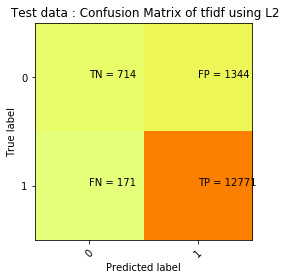

In [95]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of tfidf using L2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [96]:
# Please write all the code with proper documentation

In [97]:
tfidfl2_features_prob = tfidfl2_clf.coef_

In [98]:
len(tfidfl2_vect.get_feature_names())

49452

In [99]:
tfidfl2_pos_df = pd.DataFrame({'log prob': tfidfl2_features_prob[0],
                   'word': tfidfl2_vect.get_feature_names()[:]
                  })
tfidfl2_pos_largest_10= tfidfl2_pos_df.nlargest(10, 'log prob')


In [100]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class positive or 1 of tfidf using l2")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, tfidfl2_pos_largest_10["log prob"].values[i] ,\
               tfidfl2_pos_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class positive or 1 of tfidf using l2
+-----------------+--------------------------+-----------+
| Top ten fetures | Features Log Probability |    Word   |
+-----------------+--------------------------+-----------+
|        1        |   0.15684622667865805    |   great   |
|        2        |   0.11261095545664326    |    best   |
|        3        |   0.10788471266296434    |    love   |
|        4        |   0.10769985451819789    |    good   |
|        5        |   0.08623833725036673    | delicious |
|        6        |   0.07118406480734554    |   loves   |
|        7        |   0.07000461350858049    | excellent |
|        8        |   0.06937757437328612    |  favorite |
|        9        |   0.06830439530644257    | wonderful |
|        10       |    0.0672583161811224    |  perfect  |
+-----------------+--------------------------+-----------+


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [101]:
# Please write all the code with proper documentation

In [102]:
tfidfl2_neg_df = pd.DataFrame({'log prob': tfidfl2_features_prob[0],
                   'word': tfidfl2_vect.get_feature_names()[:]
                  })
tfidfl2_neg_largest_10= tfidfl2_neg_df.nsmallest(10, 'log prob')


In [103]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Top Ten features belonging to class negative or 0 of tfidf using l2")
x.field_names = ["Top ten fetures", "Features Log Probability", "Word"]
for i in range(0, 10):
    x.add_row([i+1, tfidfl2_neg_largest_10["log prob"].values[i] , \
                    tfidfl2_neg_largest_10["word"].values[i]])

print(x)

Top Ten features belonging to class negative or 0 of tfidf using l2
+-----------------+--------------------------+----------------+
| Top ten fetures | Features Log Probability |      Word      |
+-----------------+--------------------------+----------------+
|        1        |   -0.07091402870810747   |     worst      |
|        2        |   -0.06634434642518632   |      not       |
|        3        |   -0.06580390339413526   |  disappointed  |
|        4        |   -0.06147677551160373   |     awful      |
|        5        |   -0.0590706608163739    |    terrible    |
|        6        |   -0.05377102425755681   | disappointing  |
|        7        |  -0.053467353910719384   |    horrible    |
|        8        |   -0.05181994367989067   | disappointment |
|        9        |  -0.049112897771353616   |     stale      |
|        10       |   -0.04880941572837882   |     bland      |
+-----------------+--------------------------+----------------+


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [104]:
# Please write all the code with proper documentation

In [105]:
# Please write all the code with proper documentation
def avg_w2v(preprocessed_reviews, x, w2v_model):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())
                            
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True
    if 1 == x:
        if want_to_train_w2v:
            # min_count = 5 considers only words that occured atleast 5 times
            w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        elif want_to_use_google_w2v and is_your_ram_gt_16g:
            if os.path.isfile('GoogleNews-vectors-negative300.bin'):
                w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
                print(w2v_model.wv.most_similar('great'))
                print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

    w2v_words = list(w2v_model.wv.vocab)                      

    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec) 
    
    return sent_vectors, list_of_sentance, w2v_model                          

In [106]:
#vectorizing using above function
avg_w2v_x_train, los_train, w2v_model = avg_w2v(x_train, 1, None)
avg_w2v_x_cv, los_cv, w2v_model = avg_w2v(x_cv, 0, w2v_model)
avg_w2v_x_test, los_test, w2v_model = avg_w2v(x_test, 0, w2v_model)

In [107]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

stdize = StandardScaler(with_mean=False)
avg_w2v_x_train = stdize.fit_transform(avg_w2v_x_train)
avg_w2v_x_cv = stdize.transform(avg_w2v_x_cv)
avg_w2v_x_test = stdize.transform(avg_w2v_x_test)

In [108]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l1', C = i)
    # fitting the model on crossvalidation train
    clf.fit(avg_w2v_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(avg_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [109]:
avg_w2vl1_optimal_c = c[(auc_cv.index(max(auc_cv)))]

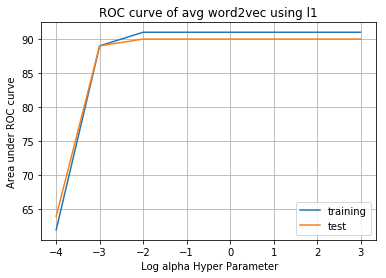

In [110]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of avg word2vec using l1")
plt.grid()
plt.show()

In [111]:
clf = LogisticRegression(penalty= 'l1',C = avg_w2vl1_optimal_c)
clf.fit(avg_w2v_x_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

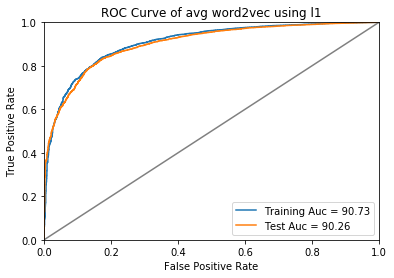

In [112]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
avg_w2vl1_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(avg_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
avg_w2vl1_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of avg word2vec using l1")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [113]:
y_pred_test = clf.predict(avg_w2v_x_test)
y_pred_cv = clf.predict(avg_w2v_x_cv)

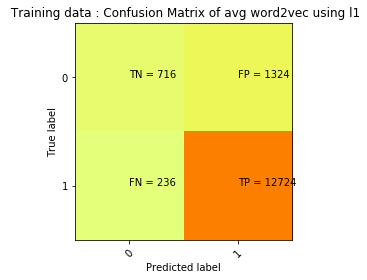

In [114]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of avg word2vec using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

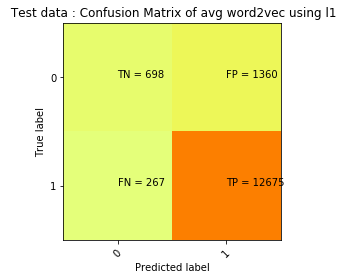

In [115]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of avg word2vec using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [116]:
# Please write all the code with proper documentation

In [117]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l2', C = i)
    # fitting the model on crossvalidation train
    clf.fit(avg_w2v_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(avg_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [118]:
avg_w2vl2_optimal_c = c[(auc_cv.index(max(auc_cv)))]

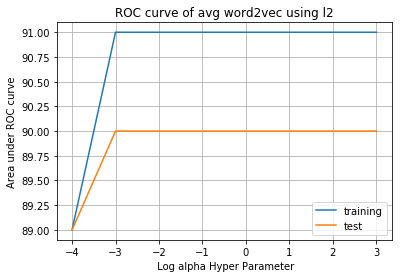

In [119]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of avg word2vec using l2")
plt.grid()
plt.show()

In [120]:
clf = LogisticRegression(penalty= 'l2',C = avg_w2vl2_optimal_c)
clf.fit(avg_w2v_x_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

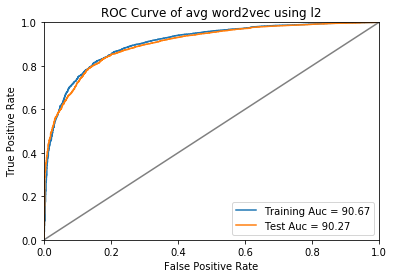

In [121]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(avg_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
avg_w2vl2_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(avg_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
avg_w2vl2_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of avg word2vec using l2")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [122]:
y_pred_test = clf.predict(avg_w2v_x_test)
y_pred_cv = clf.predict(avg_w2v_x_cv)

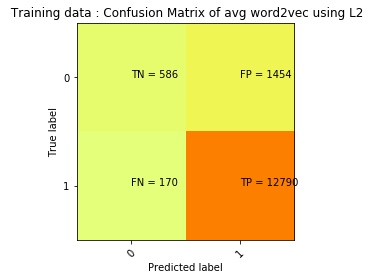

In [123]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of avg word2vec using L2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

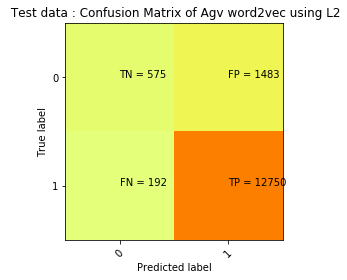

In [124]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of Agv word2vec using L2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [125]:
# Please write all the code with proper documentation

In [126]:
def tfidf_w2v(preprocessed_reviews, list_of_sentance, w2v_model, w2v_words, x, model):
    if 1 == x:
        model = TfidfVectorizer()
        tf_idf_matrix = model.fit_transform(preprocessed_reviews)
        # we are converting a dictionary with word as a key, and the idf as a value
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        # TF-IDF weighted Word2Vec
        tfidf_feat = model.get_feature_names() # tfidf words/col-names
        # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    else: 
        tf_idf_matrix = model.transform(preprocessed_reviews)
        dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
        tfidf_feat = model.get_feature_names()
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are  
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors, model                

In [127]:
#vectorizing using above function
tfidf_w2v_x_train, model = tfidf_w2v(x_train, los_train, w2v_model, list(w2v_model.wv.vocab), 1, None)
tfidf_w2v_x_cv, model = tfidf_w2v(x_cv, los_cv, w2v_model, list(w2v_model.wv.vocab), 0, model)
tfidf_w2v_x_test, model = tfidf_w2v(x_test, los_test, w2v_model, list(w2v_model.wv.vocab), 0, model)

In [128]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

stdize = StandardScaler(with_mean=False)
tfidf_w2v_x_train = stdize.fit_transform(tfidf_w2v_x_train)
tfidf_w2v_x_cv = stdize.transform(tfidf_w2v_x_cv)
tfidf_w2v_x_test = stdize.transform(tfidf_w2v_x_test)

In [129]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l1', C = i)
    # fitting the model on crossvalidation train
    clf.fit(tfidf_w2v_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(tfidf_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [130]:
tfidf_w2vl1_optimal_c = c[(auc_cv.index(max(auc_cv)))]

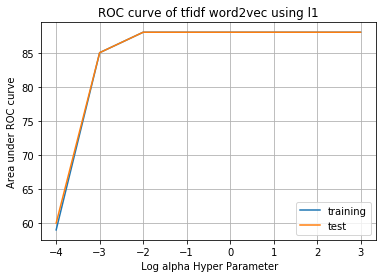

In [131]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf word2vec using l1")
plt.grid()
plt.show()

In [132]:
clf = LogisticRegression(penalty= 'l1',C = tfidf_w2vl1_optimal_c)
clf.fit(tfidf_w2v_x_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

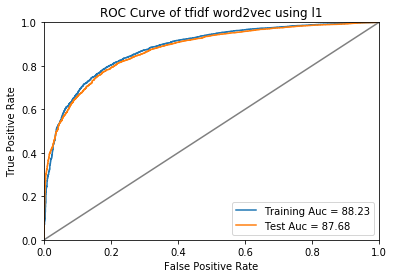

In [133]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidf_w2vl1_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(tfidf_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidf_w2vl1_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf word2vec using l1")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [134]:
y_pred_test = clf.predict(tfidf_w2v_x_test)
y_pred_cv = clf.predict(tfidf_w2v_x_cv)

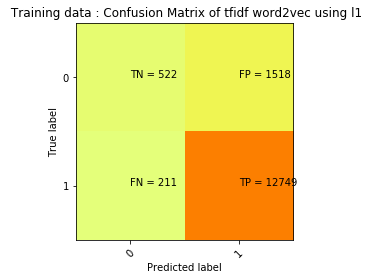

In [135]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of tfidf word2vec using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

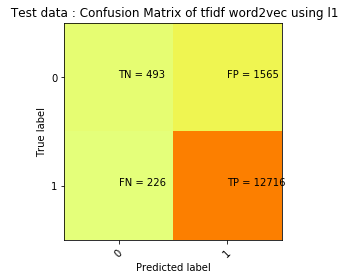

In [136]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of tfidf word2vec using l1')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [137]:
# Please write all the code with proper documentation

In [138]:
auc_cv = []
auc_test = []
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in tqdm(c):
    
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty='l2', C = i)
    # fitting the model on crossvalidation train
    clf.fit(tfidf_w2v_x_train, y_train)
    
    y_pred_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_cv,  y_pred_proba)
    auc_cv.append(np.round(metrics.roc_auc_score(y_cv, y_pred_proba)*100))
    
    y_pred_proba1 = clf.predict_proba(tfidf_w2v_x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba1)
    auc_test.append(np.round(metrics.roc_auc_score(y_test, y_pred_proba1)*100))
    

In [139]:
tfidf_w2vl2_optimal_c = c[(auc_cv.index(max(auc_cv)))]

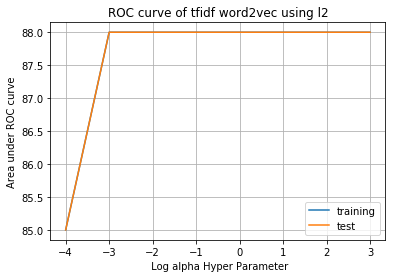

In [140]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'training': auc_cv,
                  'test': auc_test
                  }, index= log_c )

lines = df.plot.line()
plt.xlabel(" Log alpha Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.title("ROC curve of tfidf word2vec using l2")
plt.grid()
plt.show()

In [141]:
clf = LogisticRegression(penalty= 'l2',C = tfidf_w2vl2_optimal_c)
clf.fit(tfidf_w2v_x_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

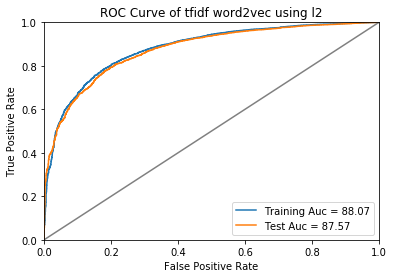

In [142]:
#auc curve of optimal k on validation and test data
y_predk_proba = clf.predict_proba(tfidf_w2v_x_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cv,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_cv, y_predk_proba)*100, 2)
tfidf_w2vl2_tr_auc = auc

plt.plot(fpr,tpr,label="Training Auc = "+str(auc))
y_predk_proba = clf.predict_proba(tfidf_w2v_x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predk_proba)
auc = np.round(metrics.roc_auc_score(y_test, y_predk_proba)*100, 2)
tfidf_w2vl2_ts_auc = auc

plt.plot(fpr,tpr,label="Test Auc = "+str(auc))
plt.legend(loc=4)
plt.plot([x/10 for x in range(0, 11)],[x/10 for x in range(0, 11)], color='grey')
plt.title("ROC Curve of tfidf word2vec using l2")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [143]:
y_pred_test = clf.predict(tfidf_w2v_x_test)
y_pred_cv = clf.predict(tfidf_w2v_x_cv)

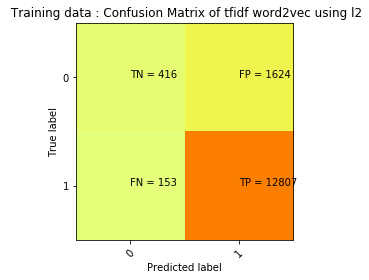

In [144]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_cv,y_pred_cv)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Training data : Confusion Matrix of tfidf word2vec using l2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

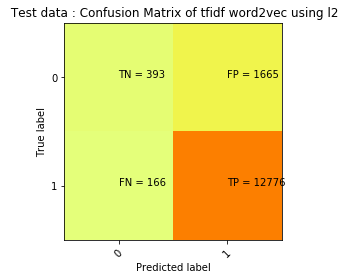

In [145]:
# http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
cm = confusion_matrix(y_test,y_pred_test)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title(' Test data : Confusion Matrix of tfidf word2vec using l2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# [6] Conclusions

In [146]:
# Please compare all your models using Prettytable library

In [147]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Technique",'Regularization', " C ", "Training Auc", "Test Auc"]
 
x.add_row(["BoW","L1", bowl1_optimal_c, bowl1_tr_auc, bowl1_ts_auc ])
x.add_row(["BoW","L2", bowl2_optimal_c, bowl2_tr_auc, bowl2_ts_auc ])
x.add_row(["TfIdf","L1", tfidfl1_optimal_c, tfidfl1_tr_auc, tfidfl1_ts_auc ])
x.add_row(["TfIdf","L2", tfidfl2_optimal_c, tfidfl2_tr_auc, tfidfl2_ts_auc ])
x.add_row(["Avg Word2vec","L1", avg_w2vl1_optimal_c, avg_w2vl1_tr_auc, avg_w2vl1_ts_auc ])
x.add_row(["Avg Word2vec","L2", avg_w2vl2_optimal_c, avg_w2vl2_tr_auc, avg_w2vl2_ts_auc ])
x.add_row(["TfIdf Word2vec","L1", tfidf_w2vl1_optimal_c, tfidf_w2vl1_tr_auc, tfidf_w2vl1_ts_auc ])
x.add_row(["TfIdf word2vec","L2", tfidf_w2vl2_optimal_c, tfidf_w2vl2_tr_auc, tfidf_w2vl2_ts_auc ])

print(x)



+-----------------+----------------+--------+--------------+----------+
| Model Technique | Regularization |   C    | Training Auc | Test Auc |
+-----------------+----------------+--------+--------------+----------+
|       BoW       |       L1       |  0.01  |    93.57     |  93.47   |
|       BoW       |       L2       | 0.001  |    90.57     |  90.68   |
|      TfIdf      |       L1       |  0.01  |    94.36     |  94.15   |
|      TfIdf      |       L2       | 0.0001 |    91.62     |  91.35   |
|   Avg Word2vec  |       L1       |  0.01  |    90.73     |  90.26   |
|   Avg Word2vec  |       L2       | 0.001  |    90.67     |  90.27   |
|  TfIdf Word2vec |       L1       |  0.01  |    88.23     |  87.68   |
|  TfIdf word2vec |       L2       | 0.001  |    88.07     |  87.57   |
+-----------------+----------------+--------+--------------+----------+


# Step for all code:

Preprocessing of the code:
    1. Importing all important library
    2. Loading data using sqlite3
    3. Making balanced data set
    4. Removing html, punctuation, from text and so on to fit into model
    5. dividing data into 3 part train test cv
Bow(l1 and l2) :
    1. fitting train to bow model and transforming with train and cv and test
    2. taking  c value from 0.0001 to 1000 with increement  multiple of 10
    4. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    3. finding c optimal 
    4. plotting roc curve of cv and test 
    5. plottinng confusion matrix of cv and test     
    6. finding the sparse weight using l1 regularization.
    7. checking multicolinearity using l2 regularization.
Tfidf and Avg word2vec and Tfidf word2vec(L1 and L2):
    1. fitting train to bow model and transforming with train and cv and test
    2. taking  c value from 0.0001 to 1000 with increement  multiple of 10
    4. ploting all alpha with corresponding with auc so thatcan visualize optimal alpha
    3. finding c optimal 
    4. plotting roc curve of cv and test 
    5. plottinng confusion matrix of cv and test

    